<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250624%5D%20FedAvg%20(MLP-LSTM%20baseline)%20%E2%80%93%20WSN-DS%20with%20CM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FedAvg (MLP-LSTM baseline)  –  WSN-DS with CM**

In [1]:
#!/usr/bin/env python3
# --------------------------------------------------------------------
#   FedAvg (MLP-LSTM baseline)  –  WSN-DS
#   ▸ identical data pipeline as TrustFed-IDS
#   ▸ weighted aggregation by client-sample count (no trust)
#   ▸ saves raw + PNG confusion matrix in /mnt/data
# --------------------------------------------------------------------
import os, time, psutil, warnings, numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix)
from imblearn.over_sampling import SMOTE
import seaborn as sns, matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# ----------------------------- CONFIG ---------------------------------
SEED, NUM_CLIENTS   = 42, 5
ROUNDS, LOCAL_EPOCHS = 30, 1
BATCH_SIZE, DIR_ALPHA = 32, 0.5
DATA_PATH, LOG_DIR    = "dataset_WSN-DS.csv", "/mnt/data"
os.makedirs(LOG_DIR, exist_ok=True)

np.random.seed(SEED); tf.random.set_seed(SEED)

# ---------------- 1. GLOBAL LOAD + SCALER -----------------------------
df = pd.read_csv(DATA_PATH).dropna()
for col in df.select_dtypes(include="object"):
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop("Class", axis=1).astype("float32").values
y = df["Class"].astype("int64").values

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED)

scaler = StandardScaler().fit(X_tr)
X_tr, X_te = scaler.transform(X_tr), scaler.transform(X_te)

n_classes  = int(y_tr.max() + 1)
INPUT_SHAPE= (X_tr.shape[1], 1)

In [3]:
# ---------------- 2. DIRICHLET SPLIT + LOCAL SMOTE --------------------
def dirichlet_split(X, y, k, alpha, rng):
    idx = {c: rng.permutation(np.where(y==c)[0]) for c in np.unique(y)}
    buckets = [[] for _ in range(k)]
    for c, ids in idx.items():
        parts = (rng.dirichlet([alpha]*k)*len(ids)).astype(int)
        while parts.sum() < len(ids): parts[rng.randint(0,k)] += 1
        s=0
        for cid, cnt in enumerate(parts):
            buckets[cid].extend(ids[s:s+cnt]); s += cnt
    for b in buckets: rng.shuffle(b)
    return [X[b] for b in buckets], [y[b] for b in buckets]

rng = np.random.RandomState(SEED)
cX_raw, cY_raw = dirichlet_split(X_tr, y_tr, NUM_CLIENTS, DIR_ALPHA, rng)

client_X, client_y = [], []
for cid,(Xi,yi) in enumerate(zip(cX_raw, cY_raw)):
    try:
        Xi, yi = SMOTE(random_state=SEED).fit_resample(Xi, yi)
        print(f"[CID {cid}] SMOTE → {len(Xi):,} samples.")
    except ValueError as e:
        print(f"[CID {cid}] SMOTE skipped ({e}); using raw data.")
    client_X.append(Xi[...,None])
    client_y.append(to_categorical(yi, n_classes))

X_te = X_te[...,None]
y_te_cat = to_categorical(y_te, n_classes)

[CID 0] SMOTE → 610,890 samples.
[CID 1] SMOTE → 649,255 samples.
[CID 2] SMOTE → 17,390 samples.
[CID 3] SMOTE → 22,745 samples.
[CID 4] SMOTE → 88,390 samples.


In [4]:
# ---------------- 3. MODEL -------------------------------------------
def build_model(inp=INPUT_SHAPE, classes=n_classes):
    m = Sequential([
        InputLayer(shape=inp),
        LSTM(128, return_sequences=True, activation='tanh',
             kernel_regularizer=l2(5e-4)),
        LSTM(64,  activation='tanh', kernel_regularizer=l2(5e-4)),
        Dense(256, activation='relu'), Dropout(0.20),
        Dense(128, activation='relu'), Dropout(0.25),
        Dense(classes, activation='softmax')
    ])
    opt = tf.keras.optimizers.Nadam(
              CosineDecay(5e-4, decay_steps=ROUNDS, alpha=0.4),
              clipnorm=2.0)
    m.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return m

# ---------------- 4. FEDERATED LOOP (FedAvg) --------------------------
g_model   = build_model()
g_weights = g_model.get_weights()
perf_log, comm_log = [], []

for r in range(1, ROUNDS+1):
    t0 = time.time()
    lw, ns, bytes_out = {}, {}, 0

    for cid in range(NUM_CLIENTS):
        n_val = max(1, int(0.15*len(client_X[cid])))
        Xv, yv = client_X[cid][:n_val], client_y[cid][:n_val]
        Xt, yt = client_X[cid][n_val:], client_y[cid][n_val:]

        local = build_model(); local.set_weights(g_weights)
        local.fit(Xt, yt, epochs=LOCAL_EPOCHS,
                  batch_size=BATCH_SIZE, verbose=0)

        lw[cid] = local.get_weights()
        ns[cid] = len(Xt)
        bytes_out += sum(w.nbytes for w in lw[cid])

    # ---- FedAvg aggregation (weight by sample count) ----
    total = sum(ns.values())
    g_weights = [np.sum([ns[c]/total * lw[c][l]
                         for c in lw], axis=0)
                 for l in range(len(g_weights))]
    g_model.set_weights(g_weights)

    # quick metrics
    y_hat = np.argmax(g_model.predict(X_te, verbose=0),1)
    perf_log.append(dict(round=r,
                         acc=accuracy_score(y_te,y_hat),
                         f1 =f1_score(y_te,y_hat,average='weighted')))
    comm_log.append(dict(round=r, MB=bytes_out/2**20))

    print(f"R{r:02d} acc={perf_log[-1]['acc']:.8f}  "
          f"F1={perf_log[-1]['f1']:.8f}  MB={bytes_out/2**20:.2f}")

R01 acc=0.84084449  F1=0.87247337  MB=3.17
R02 acc=0.62985600  F1=0.71772788  MB=3.17
R03 acc=0.85748602  F1=0.88829360  MB=3.17
R04 acc=0.84879826  F1=0.88141897  MB=3.17
R05 acc=0.94054689  F1=0.94997303  MB=3.17
R06 acc=0.94161451  F1=0.95078929  MB=3.17
R07 acc=0.92968385  F1=0.94397798  MB=3.17
R08 acc=0.93387426  F1=0.94700619  MB=3.17
R09 acc=0.93539562  F1=0.94752673  MB=3.17
R10 acc=0.94576488  F1=0.95402462  MB=3.17
R11 acc=0.92442582  F1=0.94020813  MB=3.17
R12 acc=0.93761093  F1=0.94868084  MB=3.17
R13 acc=0.94753980  F1=0.95507002  MB=3.17
R14 acc=0.94149440  F1=0.95070337  MB=3.17
R15 acc=0.94543125  F1=0.95289234  MB=3.17
R16 acc=0.94640546  F1=0.95364957  MB=3.17
R17 acc=0.94232181  F1=0.95238908  MB=3.17
R18 acc=0.94858073  F1=0.95647117  MB=3.17
R19 acc=0.95307808  F1=0.95903962  MB=3.17
R20 acc=0.95059587  F1=0.95755780  MB=3.17
R21 acc=0.95277114  F1=0.95814703  MB=3.17
R22 acc=0.95973737  F1=0.96439336  MB=3.17
R23 acc=0.95903007  F1=0.96352694  MB=3.17
R24 acc=0.9

In [5]:
# ---------------- 5. CONFUSION MATRIX ---------------------------------
print("\n✓ Training done – creating confusion matrix …")
cm = confusion_matrix(y_te, np.argmax(g_model.predict(X_te,0),1))
csv_path = f"{LOG_DIR}/cm_WSN-DS_FedAvg.csv"
png_path = csv_path.replace(".csv",".png")
np.savetxt(csv_path, cm, fmt="%d", delimiter=",")

plt.figure(figsize=(9,4))
# raw counts
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f"C{i}" for i in range(n_classes)],
            yticklabels=[f"C{i}" for i in range(n_classes)],
            linewidths=.5, linecolor='grey')
plt.title("Raw counts"); plt.xlabel("Predicted"); plt.ylabel("True")

# row-normalised
row_norm = cm / cm.sum(axis=1, keepdims=True)
plt.subplot(1,2,2)
sns.heatmap(row_norm*100, annot=True, fmt='.2f', cmap='Blues',
            cbar=False, xticklabels=[f"C{i}" for i in range(n_classes)],
            yticklabels=False, linewidths=.5, linecolor='grey')
plt.title("Row-normalised"); plt.xlabel("Predicted")

plt.suptitle("Confusion Matrix – FedAvg (WSN-DS)", y=1.02, fontsize=13)
plt.tight_layout()
plt.savefig(png_path, dpi=300); plt.close()

print("• CSV ⇒", csv_path)
print("• PNG ⇒", png_path)


✓ Training done – creating confusion matrix …
2342/2342 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
• CSV ⇒ /mnt/data/cm_WSN-DS_FedAvg.csv
• PNG ⇒ /mnt/data/cm_WSN-DS_FedAvg.png


In [6]:
# ---------------- 6. LOGS ---------------------------------------------
pd.DataFrame(perf_log).to_csv(f"{LOG_DIR}/perf_log_WSN-DS_fedavg.csv",index=False)
pd.DataFrame(comm_log).to_csv(f"{LOG_DIR}/comm_log_WSN-DS_fedavg.csv",index=False)

profile = dict(Params_MB = round(sum(w.nbytes for w in g_weights)/2**20,3),
               Rounds    = ROUNDS,
               Clients   = NUM_CLIENTS,
               PeakMem_MB= round(psutil.Process(
                               os.getpid()).memory_info().rss/2**20,2))
pd.DataFrame([profile]).to_csv(f"{LOG_DIR}/model_profile_WSN-DS_fedavg.csv",
                               index=False)
print("\n✓ All artefacts saved to", LOG_DIR)


✓ All artefacts saved to /mnt/data


In [7]:
# prompt: Download log files aboved

from google.colab import files
files.download(f"{LOG_DIR}/cm_WSN-DS_FedAvg.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
files.download(f"{LOG_DIR}/cm_WSN-DS_FedAvg.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
files.download(f"{LOG_DIR}/perf_log_WSN-DS_fedavg.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
files.download(f"{LOG_DIR}/comm_log_WSN-DS_fedavg.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
files.download(f"{LOG_DIR}/model_profile_WSN-DS_fedavg.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

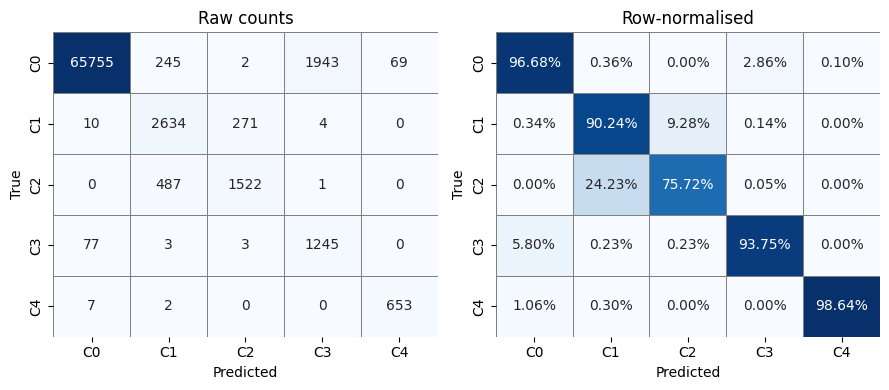

In [12]:
def plot_cm(cm, classes, title, normalise=False):
    if normalise:
        cm = cm / cm.sum(axis=1, keepdims=True)
        fmt, cmap = ".2%", "Blues"
    else:
        fmt, cmap = "d", "Blues"
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, cbar=False,
                xticklabels=classes, yticklabels=classes,
                linewidths=.5, linecolor='grey')
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(title); plt.tight_layout()

plt.figure(figsize=(9,4))
plt.subplot(1,2,1); plot_cm(cm,  [f"C{i}" for i in range(n_classes)],
                            "Raw counts", normalise=False)
plt.subplot(1,2,2); plot_cm(cm,  [f"C{i}" for i in range(n_classes)],
                            "Row-normalised", normalise=True)
plt.savefig("/mnt/data/cm_WSN-DS_dual.png", dpi=300)